In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import cbook
import random
import math
from scipy.optimize import curve_fit

#The wavelengths for these stars are limited to the ones described below.
#[J,H,Ks,3.6,4.5,5.8,8.0]
model_wavelength=[1.235e-6,1.662e-6,2.159e-6,3.55e-6,4.493e-6,5.731e-6,7.872e-6]

def find_norm(template,N):

# Multiplies inputed star model by normalization factor.

    return N*template

def remove_all_occurrences(list_obj, value):
    
# Removes an inputed value from a list/array

    while value in list_obj:
        list_obj.remove(value)
        
def find_HiRes_IR(input_star_wavelength, input_star_flux, HiRes_SED_wavelength, HiRes_SED_flux, HiRes_SED_flux_err):
    
# Takes an inputed star wavelength, inputed star flux, HiRes SED Wavelength,
# HiRes SED Flux, and HiRes SED Flux Error. The inputed star wavelength is
# matched with its closest equivalent value in the HiRes SED Wavelength,
# which is then used to find the equivalent HiRes SED Flux and 
# HiRes SED Flux Error. This matched HiRes Flux and matched 
# HiRes Flux Error is then outputted.
   
    HiRes_matched_wavelength = np.zeros(len(input_star_wavelength))
    HiRes_matched_flux = np.zeros(len(input_star_wavelength))
    HiRes_matched_flux_err = np.zeros(len(input_star_wavelength))
    temp_wavelength_array = np.zeros(100)
    
    for i in range(len(input_star_wavelength)):
        min_index = 0
        for j in range(100):
            temp_wavelength_array[j] = np.absolute(input_star_wavelength[i] - HiRes_SED_wavelength[j])            
            if(temp_wavelength_array[j]<temp_wavelength_array[j-1]):
                min_index = j        
        HiRes_matched_wavelength[i] = HiRes_SED_wavelength[min_index]
        HiRes_matched_flux[i] = HiRes_SED_flux[min_index]
        HiRes_matched_flux_err[i] = HiRes_SED_flux_err[min_index]
        
    return HiRes_matched_flux,HiRes_matched_flux_err

def star_fit_hi_res_IR(input_star_data):
    
# Reads the magnitude data of an inputed IR star and converts it to flux data.
# High Resolution models of different star classifications are also read
# to specific variables, which are then assigned to arrays. These arrays
# are then used in the find_HiRes function for each of the 11 High Resolution
# SEDs. The matched fluxes and their associated errors are fit to a curve
# using the curve_fit function. The resulting popt1 array is then used to
# create an array of Chi^2 values. The array of Chi^2 values is checked
# to see which index has the smallest value, which is then used to find
# which High Resolution SED is the best fit with the inputed star. Both
# the flux and the flux error of the best fit are used to produce a
# a filled graph of the High Resolution SED and the overlayed star SED.

    
    Jmag,Hmag,Ksmag,mag36,mag45,mag58,mag80 = np.genfromtxt(input_star_data,unpack=True,usecols=range(7))

    output_flux= [Jmag,Hmag,Ksmag,mag36,mag45,mag58,mag80] 
    
    wavelength1,norm_flux1,std1= np.genfromtxt('A_Giants_HiRes_SED.txt',unpack=True)
    wavelength2,norm_flux2,std2 = np.genfromtxt('B_Giants_HiRes_SED.txt',unpack=True)
    wavelength3,norm_flux3,std3 = np.genfromtxt('B_MainSeq_HiRes_SED.txt',unpack=True)
    wavelength4,norm_flux4,std4 = np.genfromtxt('Be_HiRes_SED.txt',unpack=True)
    wavelength5,norm_flux5,std5 = np.genfromtxt('FGK_SuperGiants_HiRes_SED.txt',unpack=True)
    wavelength6,norm_flux6,std6 = np.genfromtxt('LBVs_HiRes_SED.txt',unpack=True)
    wavelength7,norm_flux7,std7 = np.genfromtxt('M_SuperGiants_HiRes_SED.txt',unpack=True)
    wavelength8,norm_flux8,std8 = np.genfromtxt('O_MainSeq_HiRes_SED.txt',unpack=True)
    wavelength9,norm_flux9,std9 = np.genfromtxt('O_SuperGiants_HiRes_SED.txt',unpack=True)
    wavelength10,norm_flux10,std10 = np.genfromtxt('WC_HiRes_SED.txt',unpack=True)
    wavelength11,norm_flux11,std11 = np.genfromtxt('WN_HiRes_SED.txt',unpack=True)
    
    # Starstring is used to output the name of the inputed data file
    # when it is generated on a graph.
    
    starstring = str(input_star_data)
    if starstring.endswith('.txt'):
        starstring = starstring[:-4]
        
    star_type = ['A Giant','B Giant','B Main Sequence','Be Star','F, G, and K Super Giant','LBV Star','M Super Giant',
                 'O Main Sequence','O Super Giant','WC Star','WN Star']       
    norm_flux = [norm_flux1,norm_flux2,norm_flux3,norm_flux4,norm_flux5,norm_flux6,norm_flux7,norm_flux8,norm_flux9,
                 norm_flux10,norm_flux11]  
    wavelength = [wavelength1,wavelength2,wavelength3,wavelength4,wavelength5,wavelength6,wavelength7,wavelength8,
                 wavelength9,wavelength10,wavelength11]
    std = [std1,std2,std3,std4,std5,std6,std7,std8,std9,std10,std11]

    popt1 = [0,0,0,0,0,0,0,0,0,0,0]
    pcov = np.zeros(11)
    chisq1 = [0,0,0,0,0,0,0,0,0,0,0]
    best_star_fit = 0
    
    #Sets wavelength array values to 999 if the associated flux
    # is 999.
    for k in range (len(output_flux)):
        if(output_flux[k]==999):
            model_wavelength[k]=999           
    
    #Removes all occurrences of 999 from the model wavelength
    # and the output flux in order to scale graph properly
    remove_all_occurrences(model_wavelength, 999)
    remove_all_occurrences(output_flux, 999)
    
    HiRes_matched_flux = np.zeros((11,len(output_flux)))
    HiRes_matched_flux_err = np.zeros((11,len(output_flux)))
    
    for j in range(11):
        HiRes_matched_flux[j],HiRes_matched_flux_err[j] = find_HiRes_IR(model_wavelength,output_flux,wavelength[j],norm_flux[j],std[j])      
    
    sigma_ones = np.ones(len(output_flux))
    
    for i in range(11):
        popt1[i],pcov[i] = curve_fit(find_norm,HiRes_matched_flux[i],output_flux,sigma=sigma_ones/output_flux) 
        chisq1[i] = np.sum(np.abs((output_flux-find_norm(HiRes_matched_flux[i],*popt1[i]))**2/
                                  find_norm(HiRes_matched_flux_err[i],*popt1[i])**2))
    
    best_star_fit = chisq1.index(min(chisq1))
    
    best_star_error = HiRes_matched_flux_err[best_star_fit] 
    
    y_low = (norm_flux[best_star_fit] - std[best_star_fit]) * popt1[best_star_fit]
    y_high = (norm_flux[best_star_fit] + std[best_star_fit])* popt1[best_star_fit]    

    HiRes_matched_flux = find_norm(HiRes_matched_flux[i],*popt1[i])     
    
    plt.figure(3)
    plt.plot(model_wavelength,output_flux,'--o',label= starstring + ' SED')
    plt.fill_between(wavelength[best_star_fit],y_low,y_high,alpha=0.2,label= star_type[best_star_fit] + ' HiRes SED',color='tab:orange')
    plt.semilogx()
    plt.legend(fontsize=12)
    plt.xlabel(r'$\lambda$ (m)',fontsize=12)
    plt.ylabel(r'$\lambda F_{\lambda}$ (normalized)',fontsize=12)
    plt.title(starstring + ' vs ' + star_type[best_star_fit], fontsize=14)
    plt.xlim(3e-7,1e-5)
    
    print('chi^2 = {:.5f}'.format(chisq1[best_star_fit]))

chi^2 = 0.17929


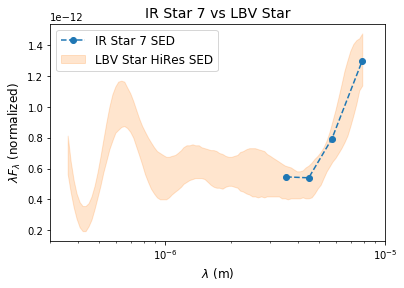

In [7]:
star_fit_hi_res_IR('IR Star 7.txt')